# Melbourne Housing Market Analysis

Objective: 

## Part 1: Data Preprocessing

#### Import Libraries 

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#### Load the dataset

In [5]:
df = pd.read_csv('data/melb_data.csv')
df.info()

print(f"\nTotal missing values: {df.isnull().sum().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [7]:
# Remove rows with missing values
df_cleaned = df.dropna()

# Final state of the dataset
print("\nCleaned dataset shape:", df_cleaned.shape)


Cleaned dataset shape: (6196, 21)


#### Summary: 

The initial dataset (df) contained 21 columns and 13,500 rows. The total amount of missing data was 13,256. 
After cleaning, the new dataset (df_cleaned) contains 21 columns and 6,196 rows. 

## Part 2: Feature Selection and Model Building: Linear Regressions

Establish a baseline model

### Exploratory data analysis for feature selection

In [11]:
# Identify numeric columns (we cannot include non-numeric in the analysis)
numeric_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

In [13]:
df_cleaned.describe() # Display basic statistics of the numerical columns

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,6196.000000,6.196000e+03,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000
mean,2.931407,1.068828e+06,9.751097,3101.947708,2.902034,1.576340,1.573596,471.006940,141.568645,1964.081988,-37.807904,144.990201,7435.489509
std,0.971079,6.751564e+05,5.612065,86.421604,0.970055,0.711362,0.929947,897.449881,90.834824,38.105673,0.075850,0.099165,4337.698917
min,1.000000,1.310000e+05,0.000000,3000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1196.000000,-38.164920,144.542370,389.000000
25%,2.000000,6.200000e+05,5.900000,3044.000000,2.000000,1.000000,1.000000,152.000000,91.000000,1940.000000,-37.855438,144.926198,4383.750000
50%,3.000000,8.800000e+05,9.000000,3081.000000,3.000000,1.000000,1.000000,373.000000,124.000000,1970.000000,-37.802250,144.995800,6567.000000
75%,4.000000,1.325000e+06,12.400000,3147.000000,3.000000,2.000000,2.000000,628.000000,170.000000,2000.000000,-37.758200,145.052700,10175.000000
max,8.000000,9.000000e+06,47.400000,3977.000000,9.000000,8.000000,10.000000,37000.000000,3112.000000,2018.000000,-37.457090,145.526350,21650.000000


In [15]:
# Calculate the correlation with the price
correlation_with_price = df_cleaned[numeric_columns].corr()['Price'].sort_values(ascending=False)
print("\nCorrelation with Price:")
print(correlation_with_price)


Correlation with Price:
Price            1.000000
Rooms            0.533505
BuildingArea     0.530574
Bedroom2         0.514561
Bathroom         0.503922
Car              0.261507
Longtitude       0.211760
Postcode         0.125539
Landsize         0.081419
Propertycount   -0.046410
Distance        -0.148867
Lattitude       -0.213574
YearBuilt       -0.304633
Name: Price, dtype: float64


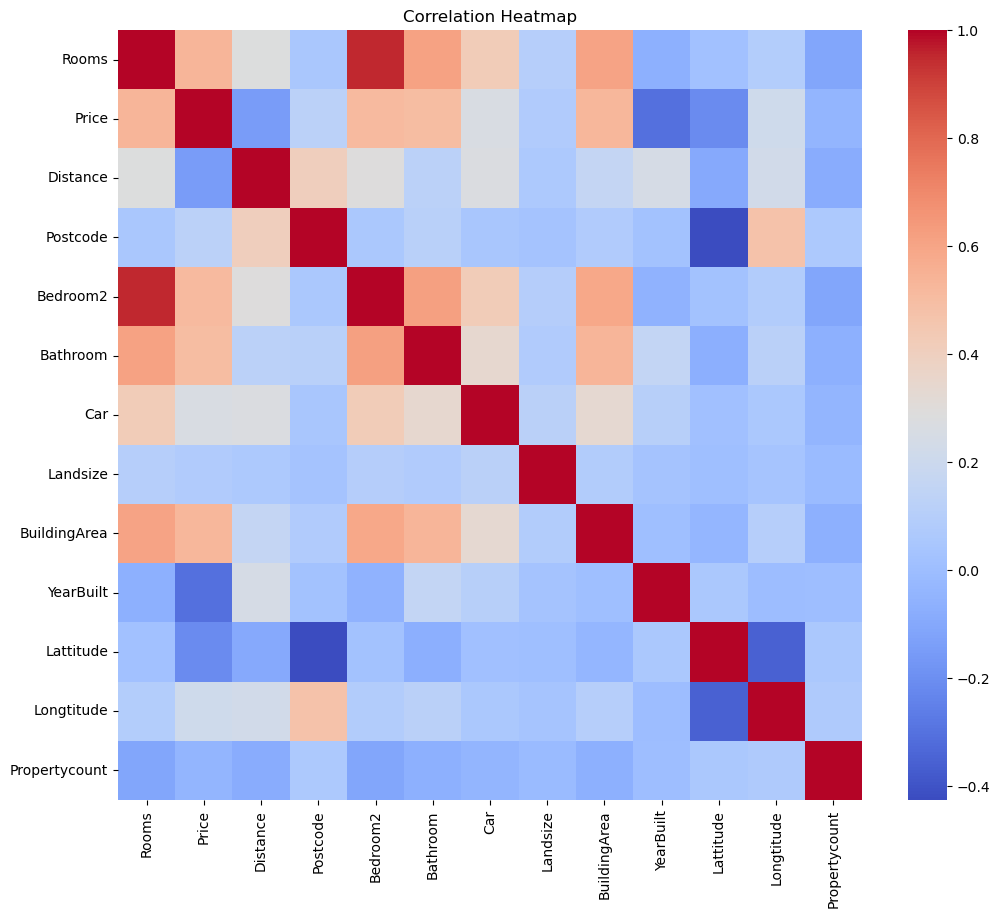

In [23]:
# Plot correlation heatmap for numeric columns
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned[numeric_columns].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
print("\nFive features that could be good predictors of house price:")
print("1. BuildingArea")
print("2. Rooms")
print("3. Landsize")
print("4. Bathroom")
print("5. Car (parking spaces)")
print("\nThis selection is based on correlation analysis for numeric features. Further analysis using non-numerical, categorical features will be performed later.")

#### Baseline Linear Model Construction

In [29]:
selected_features = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = df_cleaned[selected_features]
y = df_cleaned['Price']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construct Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Display regression coefficients
print("\nLinear Regression Coefficients:")
for feature, coef in zip(selected_features, lr_model.coef_):
    print(f"{feature}: {coef}")

# Evaluate the model
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nLinear Regression Performance:")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")


Linear Regression Coefficients:
Rooms: 292766.21816263103
Distance: -32694.67829117046
Landsize: 25.10433946839418
BuildingArea: 2266.5008860727085
YearBuilt: -3686.7790241149537

Linear Regression Performance:
MSE: 190737325986.23703
R-squared: 0.5201776395947041


## Part 3: Advanced Regression Modeling


Linear Regression Results:
Train MSE: 166660957017.71957
Test MSE: 6.468446568427342e+33
Train R2: 0.6531345115028846
Test R2: -1.6272144346001248e+22

Ridge Results:
Train MSE: 168797388290.7324
Test MSE: 131583331201.47343
Train R2: 0.6486880335129896
Test R2: 0.6689865277253675
Best parameters: {'alpha': 483.2930238571752, 'tol': 0.001}

Lasso Results:
Train MSE: 166932239971.65118
Test MSE: 133035081869.28722
Train R2: 0.6525698999944649
Test R2: 0.6653344767775596
Best parameters: {'alpha': 1000.0, 'tol': 0.0001}


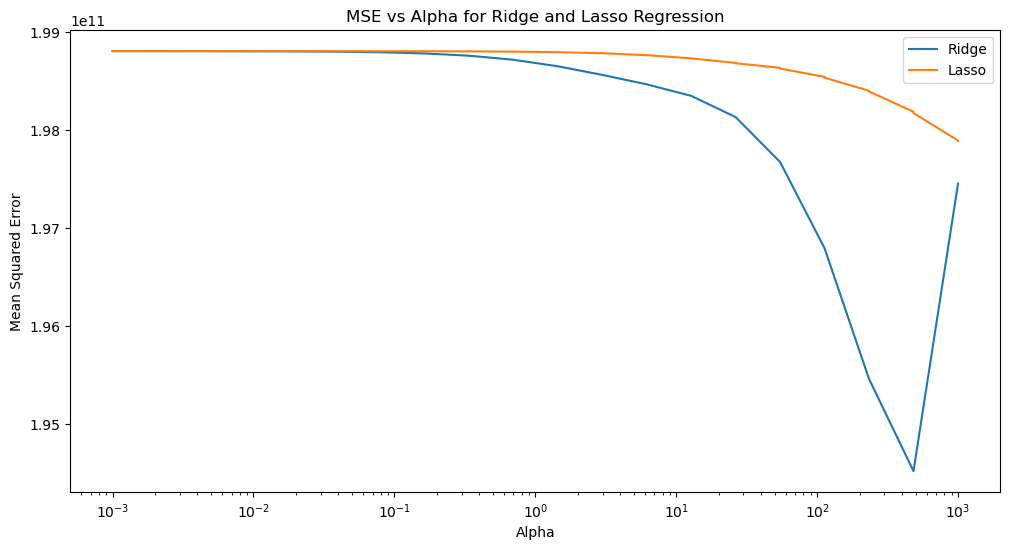

In [41]:
# Create dummy variables for 'Suburb'
df_encoded = pd.get_dummies(df_cleaned, columns=['Suburb'], drop_first=True)

# Select features for advanced models
advanced_features = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] + [col for col in df_encoded.columns if col.startswith('Suburb_')]
X_advanced = df_encoded[advanced_features]
y_advanced = df_encoded['Price']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_advanced, y_advanced, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models with adjusted parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(max_iter=10000, tol=1e-3),
    'Lasso': Lasso(max_iter=10000, tol=1e-3)
}

# Define cross-validation strategy
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Define parameter grid for Ridge and Lasso
param_grid = {
    'alpha': np.logspace(-3, 3, 20),
    'tol': [1e-3, 1e-4]  # Add tolerance to the grid search
}

# Train and evaluate models
results = {}
for name, model in models.items():
    if name in ['Ridge', 'Lasso']:
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        results[name] = {
            'model': best_model,
            'best_params': best_params,
            'train_mse': mean_squared_error(y_train, best_model.predict(X_train_scaled)),
            'test_mse': mean_squared_error(y_test, best_model.predict(X_test_scaled)),
            'train_r2': r2_score(y_train, best_model.predict(X_train_scaled)),
            'test_r2': r2_score(y_test, best_model.predict(X_test_scaled)),
            'cv_results': grid_search.cv_results_
        }
    else:
        model.fit(X_train_scaled, y_train)
        results[name] = {
            'model': model,
            'train_mse': mean_squared_error(y_train, model.predict(X_train_scaled)),
            'test_mse': mean_squared_error(y_test, model.predict(X_test_scaled)),
            'train_r2': r2_score(y_train, model.predict(X_train_scaled)),
            'test_r2': r2_score(y_test, model.predict(X_test_scaled))
        }

# Print results
for name, result in results.items():
    print(f"\n{name} Results:")
    print(f"Train MSE: {result['train_mse']}")
    print(f"Test MSE: {result['test_mse']}")
    print(f"Train R2: {result['train_r2']}")
    print(f"Test R2: {result['test_r2']}")
    if name in ['Ridge', 'Lasso']:
        print(f"Best parameters: {result['best_params']}")

# Plot alpha values against MSE scores for Ridge and Lasso
plt.figure(figsize=(12, 6))
for name in ['Ridge', 'Lasso']:
    alphas = results[name]['cv_results']['param_alpha'].data
    mean_scores = -results[name]['cv_results']['mean_test_score']
    plt.semilogx(alphas, mean_scores, label=name)
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Ridge and Lasso Regression')
plt.legend()
plt.show()

#### Summary: 

- The linear regression model performed poorly; the high test MSE and negative R2 score indicate extreme overfitting. 
- Lasso uses the maximum alpha in the grid (1000), which suggests that it is applying stronger regularization, potentially oversimplifying the model.
- Ridge provides the best predictive accuracy. It has the lowest test MSE and the highest test R2 score and balances complexity and performance well. It is also more stable across different regularization strengths. 

#### Ridge is the best model because it is best at capturing the underlying patterns in the data while avoiding overfitting.